In [1]:
import os

import numpy as np
# import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use([
  "dark_background",
  # "https://raw.githubusercontent.com/cfrontin/tools_cvf/main/tools_cvf/stylesheet_cvf.mplstyle",
  # "https://raw.githubusercontent.com/cfrontin/tools_cvf/main/tools_cvf/stylesheet_nrel.mplstyle",
])

import weis.visualization.utils as viz_toolbox
import weis.visualization.opt_plotting as opt_plotting

# Example 17: IEA22 Optimization

In this example, we can optimize a semisubmersible floating offshore wind turbine (FOWT) platform based around the IEA 22MW reference turbine.
We will consider optimizations using the following optimizers:
- COBYLA optimizer (derivative-free)
- SLSQP optimizer (gradient-based), and
- differential evolution (DE) (an evolutionary algorithm)

## Metadata loading

In the following code sections we will set up the loading of the metadata files.

In [2]:
# standard locations of output dirs based on template for ex. 17
dir_template = "17_IEA22_OptStudies/of_%s"
dir_COBYLA = dir_template % "COBYLA"
dir_SLSQP = dir_template % "SLSQP"
dir_DE = dir_template % "DE"

# OM optimization log database files
fn_log_COBYLA = os.path.join(dir_COBYLA, "log_opt.sql")
fn_log_SLSQP = os.path.join(dir_SLSQP, "log_opt.sql")
fn_log_DE = os.path.join(dir_DE, "log_opt.sql_%s")

# WEIS stashes design/constraint/objective var files located here
fn_vars_COBYLA = os.path.join(dir_COBYLA, "problem_vars.yaml")
fn_vars_SLSQP = os.path.join(dir_SLSQP, "problem_vars.yaml")
fn_vars_DE = os.path.join(dir_DE, "problem_vars.yaml")

In [3]:
# ... load the variables files
do_COBYLA = True
do_SLSQP = True
do_DE = True
unification_list = []

if do_COBYLA:
  vars_COBYLA = viz_toolbox.load_vars_file(fn_vars_COBYLA)
  unification_list.append(vars_COBYLA)
if do_SLSQP:
  vars_SLSQP = viz_toolbox.load_vars_file(fn_vars_SLSQP)
  unification_list.append(vars_SLSQP)
if do_DE:
  # vars_DE = viz_toolbox.load_vars_file(fn_vars_DE)
  vars_DE = viz_toolbox.load_vars_file(fn_vars_COBYLA)  # DEBUG!!!!!
  unification_list.append(vars_DE)
# this call verifies, (optionally) unifies, and corrects the var files
vars_unified = viz_toolbox.verify_vars(*unification_list)

## Data loading

With the metadata loaded, we can now load the primary data from the various methods.
The COBYLA and SLSQP data is loaded first, with a simple serial loader, which are used because these methods either run in a serial fashion (with F.D. derivatives calculated in parallel in the case of SLSQP).
The DE data, since it is run in parallel, is loaded using a parallel data loader.

After the data is loaded, we show any differences in the keys found between the COBYLA/SLSQP methods and pretty-print the variables with icons representing whether they are objective functions (`**`), design variables (`--`), constraints (`<>`), or other (`??`).

In [4]:
# load the data from the OM DB
if do_COBYLA:
  # dataOM_COBYLA = viz_toolbox.load_OMsql(fn_log_COBYLA)
  dataOM_COBYLA = viz_toolbox.load_OMsql(fn_log_COBYLA, parse_multi=True)
if do_SLSQP:
  # dataOM_SLSQP = viz_toolbox.load_OMsql(fn_log_SLSQP)
  dataOM_SLSQP = viz_toolbox.load_OMsql(fn_log_SLSQP, parse_multi=True)
if do_DE:
  dataOMmulti_DE = viz_toolbox.load_OMsql_multi(
    fn_log_DE % "*",
    meta_in=fn_log_DE % "meta",
  )
  dataOMbest_DE = viz_toolbox.consolidate_multi(
    dataOMmulti_DE,
    vars_DE,
  )

# describe the keys that have been found
print()
keys_all, _, _ = viz_toolbox.compare_om_data(
  # dataOM_COBYLA,
  dataOM_SLSQP,
  dataOM_SLSQP,
  # "COBYLA", "SLSQP",
  "SLSQP2", "SLSQP",
  verbose=True,
)
print()

# grab the keys that we have in the unified vars
keys_obj = [v["name"] for k, v in vars_unified["objectives"].items()]
keys_DV = [v["name"] for k, v in vars_unified["design_vars"].items()]
keys_constr = {v["name"]: [v["lower"], v["upper"]] for k, v in vars_unified["constraints"].items()}

# pretty print the case we're looking at
viz_toolbox.prettyprint_variables(keys_all, keys_obj, keys_DV, keys_constr)


the following keys are in both SLSQP2 and SLSQP:
	raft.pitch_period
	floatingse.constr_freeboard_heel_margin
	raft.heave_period
	floatingse.constr_fixed_margin
	aeroelastic.Max_PtfmPitch
	floatingse.system_structural_mass
	rank
	aeroelastic.max_nac_accel
	floating.memgrp1.outer_diameter_in
	floating.jointdv_1
	floatingse.constr_fairlead_wave
	floating.jointdv_0
	aeroelastic.Std_PtfmPitch
	floatingse.constr_variable_margin
	floatingse.constr_draft_heel_margin
	iter


<> raft.pitch_period
<> floatingse.constr_freeboard_heel_margin
<> raft.heave_period
<> floatingse.constr_fixed_margin
<> aeroelastic.Max_PtfmPitch
** floatingse.system_structural_mass
?? rank
<> aeroelastic.max_nac_accel
-- floating.memgrp1.outer_diameter_in
-- floating.jointdv_1
<> floatingse.constr_fairlead_wave
-- floating.jointdv_0
<> aeroelastic.Std_PtfmPitch
<> floatingse.constr_variable_margin
<> floatingse.constr_draft_heel_margin
?? iter



## Feasibility pre-processing

Now, we will can grab and evaluate the feasibility of the DE iterations across all the ranks.

In [5]:
if do_DE:
  # extract and install feasibility evaluations
  feas, vfeas = viz_toolbox.get_feasible_iterations(
    dataOMmulti_DE, vars_unified,
    feas_tol=1e-5,
  )
  dataOMmulti_DE["feas_total"] = feas
  for k, v in vfeas.items():
    dataOMmulti_DE[f"feas_{k}"] = v

## Plotting

### Differential Evolution results

First, we can examine the results of the DE optimization.
At each of 100 iterations, there are 104 processors working the problem.
The figure shows the progression of the optimization with feasible simulations in green, infeasible in red, the iteration-wise best result in cyan, and the value of the discovered minimizer in yellow dashes.

In the following figure, we show the iteration-over-iteration convergence of the iteration-wise best feasible estimate toward the discovered minimizer, which demonstrates regular convergence toward this value.

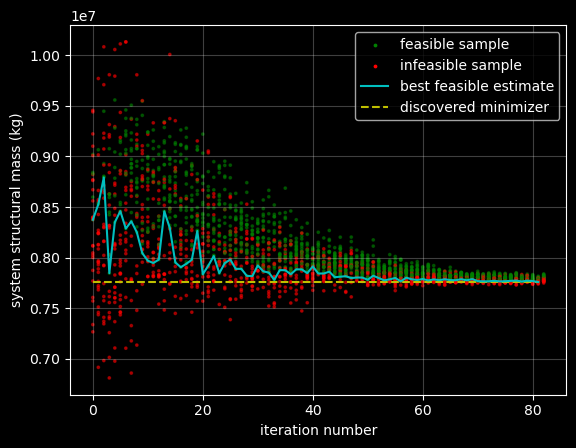

In [6]:
if do_DE:
  # plot DE results

  fig, ax = plt.subplots()
  ax.scatter([], [], s=3.0, c="g", label="feasible sample")
  ax.scatter([], [], s=3.0, c="r", label="infeasible sample")
  ax.scatter(
    dataOMmulti_DE["iter"],
    dataOMmulti_DE["floatingse.system_structural_mass"],
    s=3.0,
    c=["g" if d else "r" for d in dataOMmulti_DE["feas_total"]],
    alpha=0.5,
    label="_simulation iterations_",
  )
  ax.plot(
    range(np.max(dataOMmulti_DE["iter"])),
    [
      np.min(np.array(dataOMmulti_DE["floatingse.system_structural_mass"])[
        dataOMmulti_DE["feas_total"].flatten() & (np.array(dataOMmulti_DE["iter"]) == iter).flatten()
      ]) if len(
        np.array(dataOMmulti_DE["floatingse.system_structural_mass"])[
          dataOMmulti_DE["feas_total"].flatten() & (np.array(dataOMmulti_DE["iter"]) == iter).flatten()
        ]
      ) else np.inf for iter in range(np.max(dataOMmulti_DE["iter"]))
    ],
    c="c",
    zorder=1000,
    label="best feasible estimate",
  )
  ax.plot(
    range(np.max(dataOMmulti_DE["iter"])),
    (np.min(
      np.array(dataOMmulti_DE["floatingse.system_structural_mass"])[dataOMmulti_DE["feas_total"].flatten()]
    ) if len(
      np.array(dataOMmulti_DE["floatingse.system_structural_mass"])[dataOMmulti_DE["feas_total"].flatten()]
    ) else np.inf)*np.ones_like(range(np.max(dataOMmulti_DE["iter"]))),
    "--y",
    zorder=500,
    label="discovered minimizer",
  )
  ax.grid(which="major", alpha=0.25)
  ax.set_xlabel("iteration number")
  ax.set_ylabel("system structural mass (kg)")
  ax.legend()

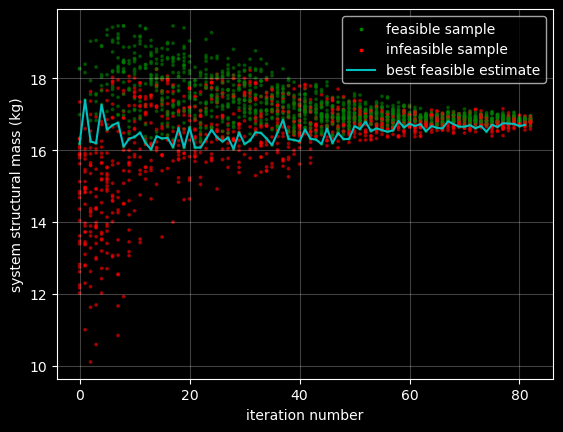

In [7]:
if do_DE:
  # plot DE results

  var_of_interest = "raft.heave_period"
  fig, ax = plt.subplots()
  ax.scatter([], [], s=3.0, c="g", label="feasible sample")
  ax.scatter([], [], s=3.0, c="r", label="infeasible sample")
  ax.scatter(
    dataOMmulti_DE["iter"],
    dataOMmulti_DE[var_of_interest],
    s=3.0,
    c=["g" if d else "r" for d in dataOMmulti_DE["feas_total"]],
    alpha=0.5,
    label="_simulation iterations_",
  )
  ax.plot(
    range(np.max(dataOMmulti_DE["iter"])),
    [
      np.min(np.array(dataOMmulti_DE[var_of_interest])[
        dataOMmulti_DE["feas_total"].flatten() & (np.array(dataOMmulti_DE["iter"]) == iter).flatten()
      ]) if len(
        np.array(dataOMmulti_DE[var_of_interest])[
          dataOMmulti_DE["feas_total"].flatten() & (np.array(dataOMmulti_DE["iter"]) == iter).flatten()
        ]
      ) else np.inf for iter in range(np.max(dataOMmulti_DE["iter"]))
    ],
    c="c",
    zorder=1000,
    label="best feasible estimate",
  )
  # ax.plot(
  #   range(np.max(dataOMmulti_DE["iter"])),
  #   (np.min(
  #     np.array(dataOMmulti_DE[var_of_interest])[dataOMmulti_DE["feas_total"].flatten()]
  #   ) if len(
  #     np.array(dataOMmulti_DE[var_of_interest])[dataOMmulti_DE["feas_total"].flatten()]
  #   ) else np.inf)*np.ones_like(range(np.max(dataOMmulti_DE["iter"]))),
  #   "--y",
  #   zorder=500,
  #   label="discovered minimizer",
  # )
  ax.grid(which="major", alpha=0.25)
  ax.set_xlabel("iteration number")
  ax.set_ylabel("system structural mass (kg)")
  ax.legend()

invalid escape sequence '\%'SyntaxWarning: <>:44
invalid escape sequence '\%'SyntaxWarning: /tmp/ipykernel_2869865/4208092425.py:44
invalid escape sequence '\%'

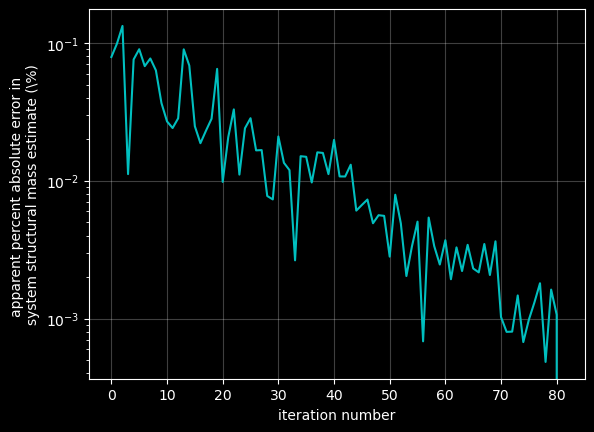

In [8]:
if do_DE:
  # plot DE optimization convergence results

  fig, ax = plt.subplots()
  ax.semilogy(
    range(np.max(dataOMmulti_DE["iter"])),
    np.abs([
      np.min(
        np.array(dataOMmulti_DE["floatingse.system_structural_mass"])[
          dataOMmulti_DE["feas_total"].flatten() & (np.array(dataOMmulti_DE["iter"]) == iter).flatten()
        ]
      ) if len(
        np.array(dataOMmulti_DE["floatingse.system_structural_mass"])[
          dataOMmulti_DE["feas_total"].flatten() & (np.array(dataOMmulti_DE["iter"]) == iter).flatten()
        ]
      ) else np.inf for iter in range(np.max(dataOMmulti_DE["iter"]))
    ]
    - (np.min(
      np.array(
        dataOMmulti_DE["floatingse.system_structural_mass"]
      )[dataOMmulti_DE["feas_total"].flatten()]
    ) if len(
      np.array(
        dataOMmulti_DE["floatingse.system_structural_mass"]
      )[dataOMmulti_DE["feas_total"].flatten()]
    ) else np.inf)*np.ones_like(range(np.max(dataOMmulti_DE["iter"]))))/(
      np.min(
        np.array(
          dataOMmulti_DE["floatingse.system_structural_mass"]
        )[dataOMmulti_DE["feas_total"].flatten()]
      ) if len(
        np.array(
          dataOMmulti_DE["floatingse.system_structural_mass"]
        )[dataOMmulti_DE["feas_total"].flatten()]
      ) else np.inf
    ),
    c="c",
    label="error in iteration-wise best feasible estimate",
  )
  ax.grid(which="major", alpha=0.25)
  ax.set_xlabel("iteration number")
  ax.set_ylabel(
    "apparent percent absolute error in "
    + "\nsystem structural mass estimate (\%)"
  )

### Combined results

With the DE results in tow, we can now evaluate them with respect to the other solutions.
In the following plots, we will evaluate the optimization trajectories of the three optimizers.
In the first plot, the objective function for optimization is shown, and in the second, the design variables are shown.
Each of the markers is either filled for a feasible sample or unfilled for infeasible sample at a given iteration.
DE results are the best-available feasible instance at a given iteration, as shown above.

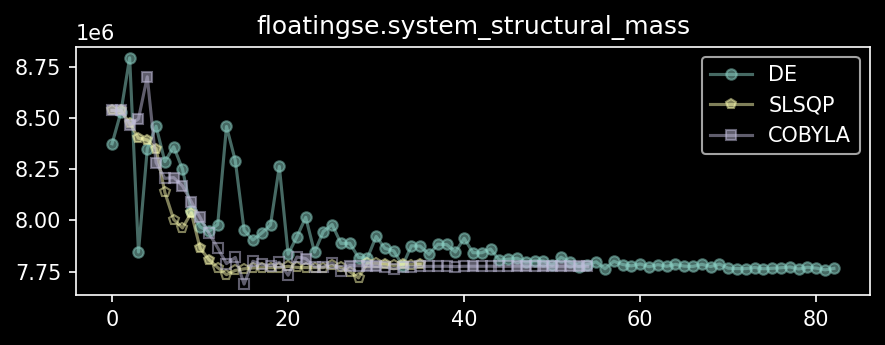

In [9]:
opt_plotting.plot_conv(
  keys_obj,
  {
    "DE": (dataOMbest_DE, vars_DE),
    "SLSQP": (dataOM_SLSQP, vars_SLSQP),
    "COBYLA": (dataOM_COBYLA, vars_COBYLA),
  },
  feas_tol=1e-3,
  alpha=0.5,
) ;

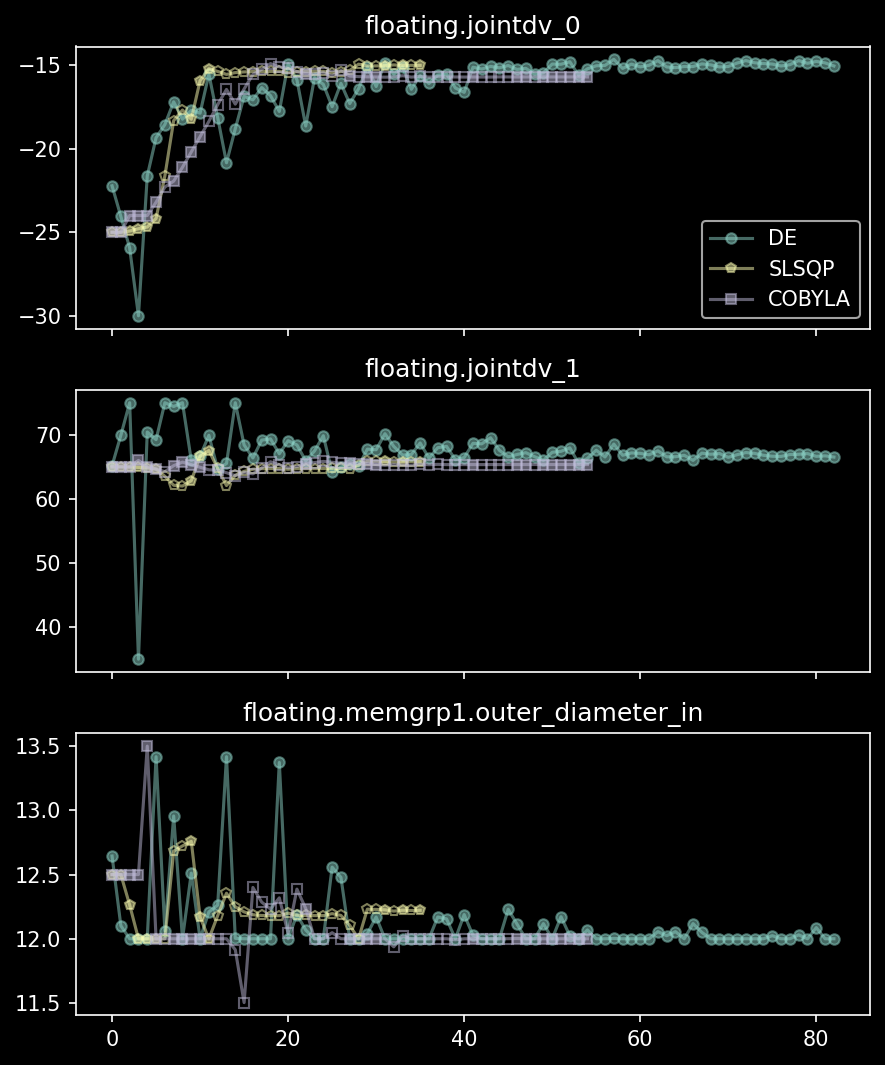

In [10]:
opt_plotting.plot_conv(
  keys_DV,
  {
    "DE": (dataOMbest_DE, vars_DE),
    "SLSQP": (dataOM_SLSQP, vars_SLSQP),
    "COBYLA": (dataOM_COBYLA, vars_COBYLA),
  },
  feas_tol=1e-3,
  alpha=0.5,
) ;

In the final subplot, below, we show the constraints active on the problem, which are numerous.
In this plot, filled (unfilled) markers represent feasibility (infeasibility) according to the constraint of interest on the displayed iteration.

divide by zero encountered in log10

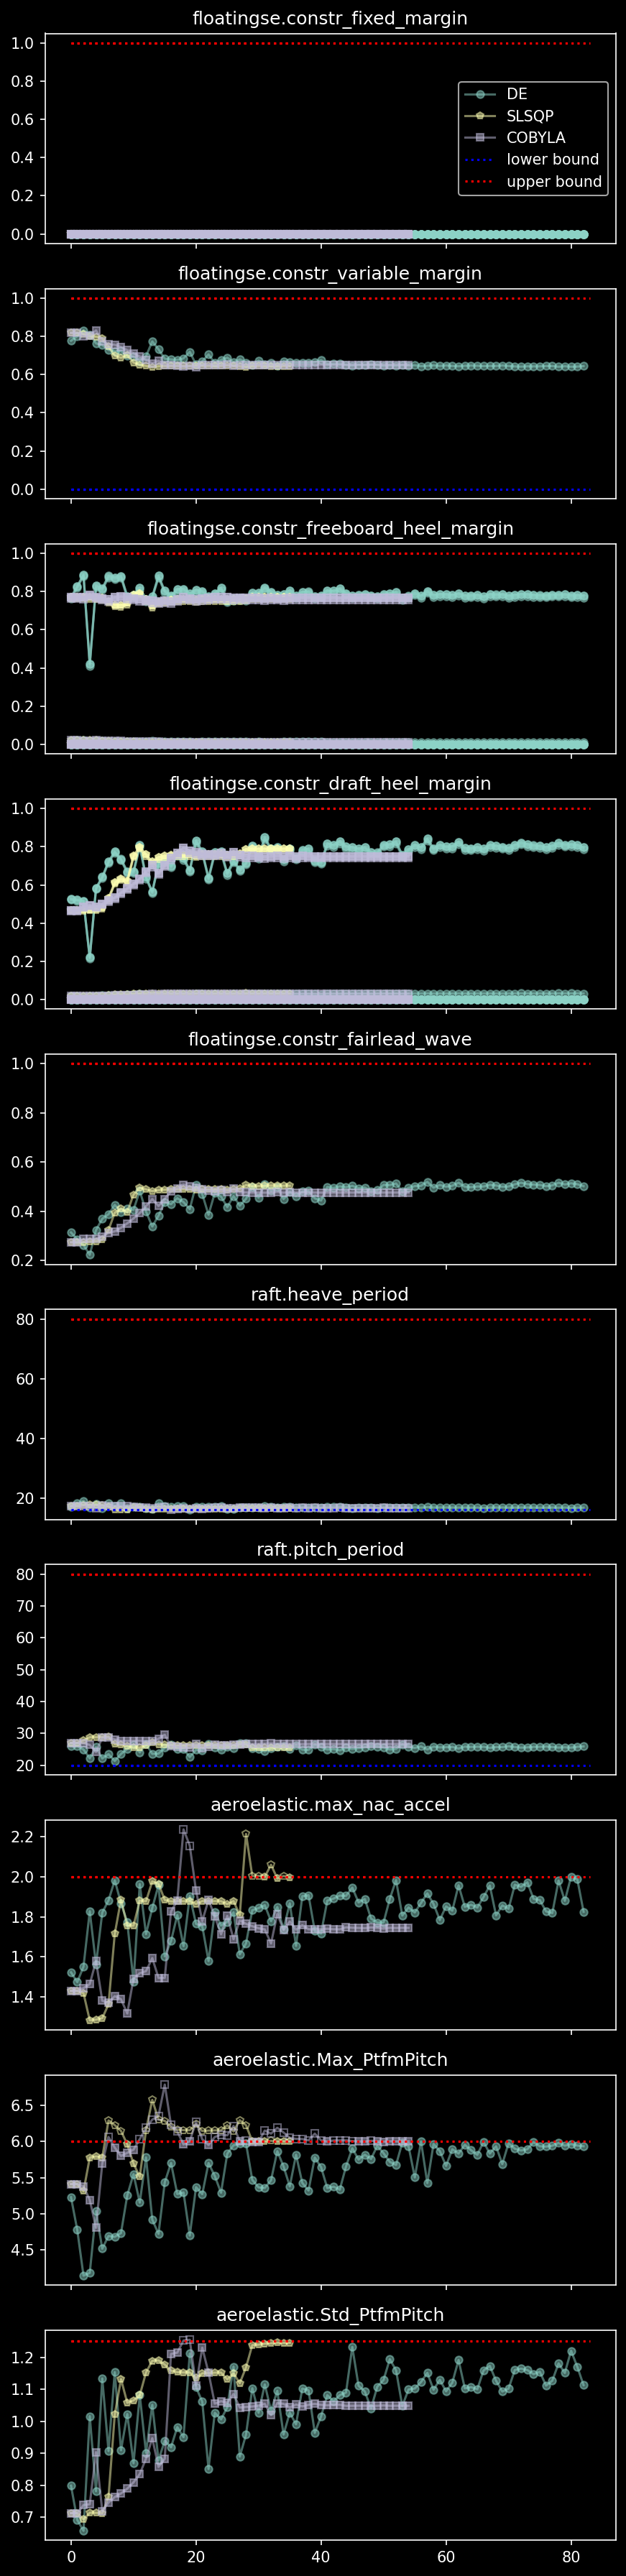

In [11]:
opt_plotting.plot_conv(
  keys_constr,
  {
    "DE": (dataOMbest_DE, vars_DE),
    "SLSQP": (dataOM_SLSQP, vars_SLSQP),
    "COBYLA": (dataOM_COBYLA, vars_COBYLA),
  },
  feas_tol=1e-3,
  alpha=0.5,
  use_casewise_feasibility=True,
) ;